In [57]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings('ignore')




In [59]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

# 1- CARREGAMENTO DO DATASET

In [3]:
#CARREGA O DATASET
df = pd.read_csv('dados_streaming.csv')


In [4]:
#df.shape mostra quantas linhas e colunas há na base.
print(f"Shape: {df.shape} (linhas, colunas)")


Shape: (30000, 18) (linhas, colunas)


In [5]:
#df.head() mostra as primeiras 5 linhas para conferir se tudo veio certo.
print(f"\n Primeiras 5 linhas:")
print(df.head())


 Primeiras 5 linhas:
   cliente_id  idade    genero  parceiro  dependentes  acessibilidade  \
0  CLI_000001   29.0  Feminino       1.0          NaN               0   
1  CLI_000002   69.0  Feminino       NaN          0.0               0   
2  CLI_000003   61.0  Feminino       1.0          0.0               0   
3  CLI_000004   33.0  Feminino       1.0          1.0               0   
4  CLI_000005   54.0  Feminino       1.0          0.0               0   

   tempo_assinatura_meses plano_assinatura  valor_mensal  visualizacoes_mes  \
0                    53.0           Padrão          29.9                  2   
1                     NaN          Premium          39.9                 72   
2                    19.0           Básico          19.9                 11   
3                     NaN           Básico          19.9                 44   
4                    19.0           Básico          19.9                 97   

   tempo_medio_sessao_min  avaliacao_conteudo  media_avaliacao_p

In [6]:
#df.columns.tolist() lista todos os nomes de colunas para definirmos o alvo (churn) e as features.
print(" Colunas:")
print(df.columns.tolist())

 Colunas:
['cliente_id', 'idade', 'genero', 'parceiro', 'dependentes', 'acessibilidade', 'tempo_assinatura_meses', 'plano_assinatura', 'valor_mensal', 'visualizacoes_mes', 'tempo_medio_sessao_min', 'avaliacao_conteudo', 'media_avaliacao_plataforma', 'formato_mais_assistido', 'contatos_suporte', 'metodo_pagamento', 'dispositivo_principal', 'churn']


# 2- ANÁLISE DA ESTRUTURA COMPLETA

**O que cada análise faz:**

*   *df.info() → Tipos + memória usada*
*   *isnull().sum() → NaN por coluna (pra limpar depois)*
*   *describe() → Médias, desvios, min/max numéricas*
*   *Target detector → Procura churn/status automaticamente*
*   *Categóricas  → Distribuição pra entender encoding necessário*








In [7]:
#INSPEÇÃO DETALHADA DO SEU DATASET.
print("\n INFO DOS TIPOS DE DADOS:")
print(df.info())


 INFO DOS TIPOS DE DADOS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cliente_id                  30000 non-null  object 
 1   idade                       29603 non-null  float64
 2   genero                      30000 non-null  object 
 3   parceiro                    25500 non-null  float64
 4   dependentes                 26400 non-null  float64
 5   acessibilidade              30000 non-null  int64  
 6   tempo_assinatura_meses      27800 non-null  float64
 7   plano_assinatura            30000 non-null  object 
 8   valor_mensal                30000 non-null  float64
 9   visualizacoes_mes           30000 non-null  int64  
 10  tempo_medio_sessao_min      30000 non-null  int64  
 11  avaliacao_conteudo          26465 non-null  float64
 12  media_avaliacao_plataforma  28509 non-null  float64
 13  form

In [8]:
#VALORES NULOS POR COLUNA.
print(" VALORES NULOS POR COLUNA:")
print(df.isnull().sum())

 VALORES NULOS POR COLUNA:
cliente_id                       0
idade                          397
genero                           0
parceiro                      4500
dependentes                   3600
acessibilidade                   0
tempo_assinatura_meses        2200
plano_assinatura                 0
valor_mensal                     0
visualizacoes_mes                0
tempo_medio_sessao_min           0
avaliacao_conteudo            3535
media_avaliacao_plataforma    1491
formato_mais_assistido           0
contatos_suporte               478
metodo_pagamento                 0
dispositivo_principal            0
churn                            0
dtype: int64


In [9]:
#ESTATÍSTICAS NUMÉRICAS.
print(" ESTATÍSTICAS NUMÉRICAS:")
print(df.describe())

 ESTATÍSTICAS NUMÉRICAS:
              idade      parceiro   dependentes  acessibilidade  \
count  29603.000000  25500.000000  26400.000000    30000.000000   
mean      47.804952      0.751725      0.301439        0.149567   
std       16.881204      0.432020      0.458892        0.356652   
min       19.000000      0.000000      0.000000        0.000000   
25%       33.000000      1.000000      0.000000        0.000000   
50%       48.000000      1.000000      0.000000        0.000000   
75%       62.000000      1.000000      1.000000        0.000000   
max       77.000000      1.000000      1.000000        1.000000   

       tempo_assinatura_meses  valor_mensal  visualizacoes_mes  \
count            27800.000000   30000.00000       30000.000000   
mean                34.600036      25.91300          51.495533   
std                 17.037905       7.34318          28.707340   
min                  1.000000      19.90000           0.000000   
25%                 20.000000      19.900

In [10]:
#IDENTIFICANDO POSSÍVEL TARGET (Churn/Cancelamento).
# Procura colunas que podem ser target.
print("IDENTIFICANDO POSSÍVEL TARGET (Churn/Cancelamento):")
target_cols = [col for col in df.columns if any(word in col.lower() for word in ['churn', 'cancel', 'sair', 'status'])]
print("Possíveis targets:", target_cols)


IDENTIFICANDO POSSÍVEL TARGET (Churn/Cancelamento):
Possíveis targets: ['churn']


In [11]:
#DISTRIBUIÇÃO PRIMEIRAS CATEGÓRICAS.
# Mostra distribuição das primeiras 3 colunas categóricas.
print(" DISTRIBUIÇÃO PRIMEIRAS CATEGÓRICAS:")
cat_cols = df.select_dtypes(include=['object']).columns[:3]
for col in cat_cols:
    print(f"\n{col}:")
    print(df[col].value_counts().head())

 DISTRIBUIÇÃO PRIMEIRAS CATEGÓRICAS:

cliente_id:
cliente_id
CLI_029984    1
CLI_029983    1
CLI_029982    1
CLI_029981    1
CLI_029980    1
Name: count, dtype: int64

genero:
genero
Feminino         15384
Masculino        14467
Outros             109
Não Informado       40
Name: count, dtype: int64

plano_assinatura:
plano_assinatura
Básico     16453
Padrão      9055
Premium     4492
Name: count, dtype: int64


# 3- LIMPEZA DE DADOS

**O que cada Limpeza e Preparação dos Dados para Modelagem de Churn faz.**



*  *Faz uma cópia do dataframe para não estragar o original.*
*  *Remove a coluna de ID, que não ajuda o modelo.*
*  *Separa colunas numéricas e colunas categóricas.*
*  *Tira churn da lista de numéricas, porque é o alvo.*
*  *Nas numéricas, troca faltantes pela mediana da coluna.*
*  *Nas categóricas, troca faltantes pela categoria mais comum.*
*  *No final, confere se todas as colunas ficaram sem valores nulos.*






In [12]:
# LIMPEZA E PREPARAÇÃO INICIAL.
# Cópia de trabalho.
df_clean = df.copy()


In [13]:
#Remove coluna de ID se existir.
cols_to_drop = [col for col in ['cliente_id'] if col in df_clean.columns]
df_clean = df_clean.drop(columns=cols_to_drop)

In [14]:
#Separa tipos.
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

In [15]:
# garante que o target não entre na lista numérica.
# remove target da lista numérica.
if 'churn' in num_cols:
    num_cols.remove('churn')

In [16]:
# Imputação numérica (mediana).
num_imputer = SimpleImputer(strategy='median')
df_clean[num_cols] = num_imputer.fit_transform(df_clean[num_cols])

In [17]:
# Imputação categórica (mais frequente).
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_clean[cat_cols] = cat_imputer.fit_transform(df_clean[cat_cols])

In [18]:
# Checagem
print("Valores nulos após limpeza:")
print(df_clean.isnull().sum())

Valores nulos após limpeza:
idade                         0
genero                        0
parceiro                      0
dependentes                   0
acessibilidade                0
tempo_assinatura_meses        0
plano_assinatura              0
valor_mensal                  0
visualizacoes_mes             0
tempo_medio_sessao_min        0
avaliacao_conteudo            0
media_avaliacao_plataforma    0
formato_mais_assistido        0
contatos_suporte              0
metodo_pagamento              0
dispositivo_principal         0
churn                         0
dtype: int64


# A1- Seleção de features focadas no valor para a empresa

In [19]:
#Lista de features core de negócio.
features_core = [
    'tempo_assinatura_meses',   # fidelidade / tempo de casa
    'valor_mensal',             # quanto o cliente paga
    'plano_assinatura',         # tipo de plano (Básico/Padrão/Premium)
    'visualizacoes_mes',        # engajamento com a plataforma
    'tempo_medio_sessao_min',   # tempo médio de uso
    'avaliacao_conteudo',       # satisfação com o catálogo
    'media_avaliacao_plataforma', # satisfação com a experiência/plataforma
    'contatos_suporte',         # nível de problema/insatisfação
    'metodo_pagamento',         # risco de inadimplência / fricção
    'formato_mais_assistido',   # preferência de conteúdo
    'dispositivo_principal'     # canal principal de uso
]


In [20]:
# Garante que todas existem na base limpa.
features_core = [f for f in features_core if f in df_clean.columns]


In [21]:
#Define X e y usando só features de negócio.
X = df_clean[features_core]
y = df_clean['churn']

In [22]:
print("Features usadas no modelo:", features_core)
print("Shape X:", X.shape)
print("Shape y:", y.shape)

Features usadas no modelo: ['tempo_assinatura_meses', 'valor_mensal', 'plano_assinatura', 'visualizacoes_mes', 'tempo_medio_sessao_min', 'avaliacao_conteudo', 'media_avaliacao_plataforma', 'contatos_suporte', 'metodo_pagamento', 'formato_mais_assistido', 'dispositivo_principal']
Shape X: (30000, 11)
Shape y: (30000,)


# A2 – Selecão de features focadas em churn

**Explicando:**


*   *faixa_tempo_assinatura: transforma meses em grupos (novos, médios, antigos), o que costuma correlacionar melhor com churn.*
*   *valor_por_hora: combina preço e uso; cliente que paga caro e usa pouco é mais provável de cancelar.*
*   *engajamento_nivel: categoriza engajamento em baixo/médio/alto, facilitando para o modelo e para o negócio entender*
*   *satisfacao_media: junta as duas notas de satisfação em um índice único.*
*   *alto_atrito: marca quem está no quartil superior de contatos de suporte (problema recorrente).*



In [23]:
# Trabalha em cima do df_clean já sem nulos.
df_fe = df_clean.copy()

In [24]:
#Faixas de tempo de assinatura (clientes novos x antigos).
max_tempo = df_fe['tempo_assinatura_meses'].max()

df_fe['faixa_tempo_assinatura'] = pd.cut(
    df_fe['tempo_assinatura_meses'],
    bins=[0, 6, 12, 24, 60, max_tempo + 0.01],   # garante último limite um pouco maior
    labels=['<=6m', '6-12m', '12-24m', '24-60m', f'>{60}m'],
    include_lowest=True
)


In [25]:
#Relação valor x uso (caro e pouco uso = maior risco).
df_fe['valor_por_hora'] = df_fe['valor_mensal'] / (df_fe['tempo_medio_sessao_min'] / 60 + 1)

In [26]:
#Nível de engajamento (baixo, médio, alto) pelas visualizações.
q1 = df_fe['visualizacoes_mes'].quantile(0.33)
q2 = df_fe['visualizacoes_mes'].quantile(0.66)

def class_engajamento(x):
    if x <= q1:
        return 'baixo'
    elif x <= q2:
        return 'medio'
    else:
        return 'alto'

df_fe['engajamento_nivel'] = df_fe['visualizacoes_mes'].apply(class_engajamento)

In [27]:
#Satisfação média geral (conteúdo + plataforma).
df_fe['satisfacao_media'] = (
    df_fe['avaliacao_conteudo'].fillna(0) +
    df_fe['media_avaliacao_plataforma'].fillna(0)
) / 2

In [28]:
#Indicador de alto atrito (muitos contatos de suporte).
limite_contatos = df_fe['contatos_suporte'].quantile(0.75)
df_fe['alto_atrito'] = (df_fe['contatos_suporte'] >= limite_contatos).astype(int)

# Atualiza X e y com o novo dataframe.
features_core_ext = [
    'tempo_assinatura_meses',
    'valor_mensal',
    'plano_assinatura',
    'visualizacoes_mes',
    'tempo_medio_sessao_min',
    'avaliacao_conteudo',
    'media_avaliacao_plataforma',
    'contatos_suporte',
    'metodo_pagamento',
    'formato_mais_assistido',
    'dispositivo_principal',
    'faixa_tempo_assinatura',
    'valor_por_hora',
    'engajamento_nivel',
    'satisfacao_media',
    'alto_atrito'
]

X = df_fe[features_core_ext]
y = df_fe['churn']

print("Novas features criadas:", [c for c in features_core_ext if c not in features_core])
print("Shape X:", X.shape)

Novas features criadas: ['faixa_tempo_assinatura', 'valor_por_hora', 'engajamento_nivel', 'satisfacao_media', 'alto_atrito']
Shape X: (30000, 16)


#4– TRAIN/TEST SPLIT + PRÉ-PROCESSAMENTO.
       
---StandardScaler + OneHotEncoder---












**O que esse teste faz.**


*   *train_test_split divide a base em treino (80%) e teste (20%), mantendo a proporção de churn com stratify.*

*  *Separa quais colunas são numéricas e quais são categóricas em X.*

*   *StandardScaler padroniza numéricas (média 0, desvio 1), o que melhora convergência e desempenho da regressão logística.*
*   *OneHotEncoder converte texto (plano, método de pagamento etc.) em variáveis binárias para os modelos conseguirem usar.*

*   *ColumnTransformer junta tudo em um único objeto de pré-processamento que depois será encaixado no Pipeline com os modelos.*





In [29]:
#Separação treino/teste (com estratificação).
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # mantém proporção de churn em treino e teste [web:24].
)

print("Treino:", X_train.shape, "| Teste:", X_test.shape)


Treino: (24000, 16) | Teste: (6000, 16)


In [30]:
#Identifica colunas numéricas e categóricas dentro do X.
num_cols_model = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols_model = X.select_dtypes(include=['object']).columns.tolist()

print("Numéricas:", num_cols_model)
print("Categóricas:", cat_cols_model)

Numéricas: ['tempo_assinatura_meses', 'valor_mensal', 'visualizacoes_mes', 'tempo_medio_sessao_min', 'avaliacao_conteudo', 'media_avaliacao_plataforma', 'contatos_suporte', 'valor_por_hora', 'satisfacao_media', 'alto_atrito']
Categóricas: ['plano_assinatura', 'metodo_pagamento', 'formato_mais_assistido', 'dispositivo_principal', 'engajamento_nivel']


In [31]:
#Cria pré-processador (escalonamento + one-hot).
numeric_transformer = StandardScaler()  # deixa todas as numéricas na mesma escala, ajuda a Regressão Logística [web:24].
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # transforma categorias em colunas binárias [web:25].
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols_model),
        ('cat', categorical_transformer, cat_cols_model)
    ]
)

#5- MODELAGEM: REGRESSÃO LOGÍSTICA E RANDOM FOREST

#  Regressão logística


*   *Classe 0 (não churn):*
*   *precision ≈ 0.67, recall = 1.00, f1 ≈ 0.80.*
*   *Ou seja, acerta quase todos os clientes que ficam*.
*   **Classe 1 (churn):**
*   *precision ≈ 0.43, recall ≈ 0.01, f1 ≈ 0.01.*
*   *Quase nenhum churn real é previsto como churn; o modelo “tem medo” de marcar cliente como risco.*
*   *Acurácia ≈ 0.67 e ROC‑AUC ≈ 0.58, mostrando que o modelo separa um pouco melhor que o acaso, mas ainda é fraco para decisão de negócio.*


Obs: Em termos práticos, a utilização desta versão do modelo implicaria na classificação da grande maioria dos clientes como “vai continuar”, o que impediria a área de Retenção de identificar, com confiabilidade, quais usuários estão efetivamente em risco de cancelamento.



In [32]:
#Pipeline Regressão Logística.
log_reg_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),                 # aplica scaler + one-hot
    ('model', LogisticRegression(max_iter=1000))  # modelo linear para churn
])

log_reg_pipeline.fit(X_train, y_train)
y_pred_log = log_reg_pipeline.predict(X_test)
y_prob_log = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("=== Regressão Logística ===")
print(classification_report(y_test, y_pred_log))          # precision, recall, f1 por classe
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))      # medida global de separação das classes
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_log))


=== Regressão Logística ===
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      4002
           1       0.43      0.01      0.01      1998

    accuracy                           0.67      6000
   macro avg       0.55      0.50      0.40      6000
weighted avg       0.59      0.67      0.54      6000

ROC-AUC: 0.5774685229957593
Matriz de confusão:
 [[3989   13]
 [1988   10]]


# Random Forest “puro” (sem class_weight, threshold 0.5)

*   *Classe 1 (churn): recall ≈ 0.04, f1 ≈ 0.08.*
*   *ROC-AUC ≈ 0.55.*

Obs: O modelo quase não marca churn; prefere dizer que todo mundo fica.



In [33]:
#Pipeline Random Forest.
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),                           # mesmo pré-processamento
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.67      0.97      0.79      4002
           1       0.45      0.04      0.08      1998

    accuracy                           0.66      6000
   macro avg       0.56      0.51      0.44      6000
weighted avg       0.60      0.66      0.56      6000

ROC-AUC: 0.5483713973843909
Matriz de confusão:
 [[3894  108]
 [1910   88]]


# ==============================================
# MODELOS AJUSTADOS PARA CHURN (CLASS_WEIGHT E THRESHOLD)
# ==============================================


# Versões com Classes Balanceadas

**Regressão Logística balanceada (class_weight='balanced')**



*   *Churn: recall ≈ 0.55, f1 ≈ 0.45.*

*   *Acurácia ≈ 0.55, ROC-AUC ≈ 0.58.*


Obs: Já existe um compromisso melhor: perde um pouco de acurácia, mas começa a enxergar uma parte razoável dos churns.




In [34]:
# Regressão Logística com pesos balanceados.
log_reg_bal = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg_bal.fit(X_train, y_train)
y_pred_log_bal = log_reg_bal.predict(X_test)
y_prob_log_bal = log_reg_bal.predict_proba(X_test)[:, 1]

print("=== Logística Balanceada ===")
print(classification_report(y_test, y_pred_log_bal))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log_bal))




=== Logística Balanceada ===
              precision    recall  f1-score   support

           0       0.71      0.56      0.62      4002
           1       0.38      0.55      0.45      1998

    accuracy                           0.55      6000
   macro avg       0.55      0.55      0.54      6000
weighted avg       0.60      0.55      0.57      6000

ROC-AUC: 0.5773752263007635


# Random Forest balanceado

**Muito fraco para identificar quem churnou.**

*   *Classe 0 (não churn):*
*   *precision ≈ 0.67, recall ≈ 0.98, f1 ≈ 0.79.*

*   *Classe 1 (churn):*
*   *precision ≈ 0.36, recall ≈ 0.03, f1 ≈ 0.05.*

*   Acurácia global ≈ 0.66, mas o ROC‑AUC ≈ 0.55 mostra que a capacidade de separar as duas classes é só um pouco melhor que o acaso.
*texto em itálico*




Obs: A empresa teria um modelo confiável para dizer “este cliente provavelmente não vai sair”, mas quase nenhum alerta útil sobre quem está prestes a cancelar.

Mesmo com class_weight='balanced', o algoritmo continua “conservador” na classe 1, por isso a gente testou reduzir o threshold para 0.3, aumentando o recall de churn às custas da acurácia e de mais falsos positivos.




In [35]:
# Random Forest com pesos balanceados.
rf_bal = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

rf_bal.fit(X_train, y_train)
y_pred_rf_bal = rf_bal.predict(X_test)
y_prob_rf_bal = rf_bal.predict_proba(X_test)[:, 1]

print("\n=== Random Forest Balanceado ===")
print(classification_report(y_test, y_pred_rf_bal))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf_bal))


=== Random Forest Balanceado ===
              precision    recall  f1-score   support

           0       0.67      0.98      0.79      4002
           1       0.36      0.03      0.05      1998

    accuracy                           0.66      6000
   macro avg       0.51      0.50      0.42      6000
weighted avg       0.56      0.66      0.55      6000

ROC-AUC: 0.5492058775417096


# Random Forest balanceado com threshold 0.3



*   *Churn: recall ≈ 0.70, f1 ≈ 0.47.*
*   *Acurácia cai para ≈ 0.47.*

Obs: Esse cenário é típico de churn: o modelo erra mais “não churn”, mas acerta bem mais quem está em risco, o que é útil se a empresa aceita abordar mais gente para não perder clientes de alto valor.


In [36]:
# Random Forest balanceado com threshold 0.3.
threshold = 0.3
y_pred_rf_tuned = (y_prob_rf_bal >= threshold).astype(int)

print("=== Random Forest (threshold 0.3) ===")
print(classification_report(y_test, y_pred_rf_tuned))


=== Random Forest (threshold 0.3) ===
              precision    recall  f1-score   support

           0       0.70      0.36      0.48      4002
           1       0.35      0.70      0.47      1998

    accuracy                           0.47      6000
   macro avg       0.53      0.53      0.47      6000
weighted avg       0.59      0.47      0.47      6000



# ==============================================
# MODELO FINAL (THRESHOLD PADRÃO + 0.3)
# ==============================================


#6 –  MODELO - FINAL

**Random Forest balanceado**

In [37]:
# Modelo final escolhido.
modelo_final = rf_bal  # Random Forest balanceado.

# Avaliação com threshold padrão (0.5).
y_pred_final = modelo_final.predict(X_test)
y_prob_final = modelo_final.predict_proba(X_test)[:, 1]

print("=== Modelo Final: Random Forest Balanceado (threshold 0.5) ===")
print(classification_report(y_test, y_pred_final))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_final))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_final))


=== Modelo Final: Random Forest Balanceado (threshold 0.5) ===
              precision    recall  f1-score   support

           0       0.67      0.98      0.79      4002
           1       0.36      0.03      0.05      1998

    accuracy                           0.66      6000
   macro avg       0.51      0.50      0.42      6000
weighted avg       0.56      0.66      0.55      6000

ROC-AUC: 0.5492058775417096
Matriz de confusão:
 [[3903   99]
 [1943   55]]


**Random Forest balanceado com threshold 0.3**


In [38]:
threshold_negocio = 0.3
y_pred_thresh = (y_prob_final >= threshold_negocio).astype(int)

print(f"\n=== Modelo Final: RF Balanceado (threshold {threshold_negocio}) ===")
print(classification_report(y_test, y_pred_thresh))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_thresh))



=== Modelo Final: RF Balanceado (threshold 0.3) ===
              precision    recall  f1-score   support

           0       0.70      0.36      0.48      4002
           1       0.35      0.70      0.47      1998

    accuracy                           0.47      6000
   macro avg       0.53      0.53      0.47      6000
weighted avg       0.59      0.47      0.47      6000

Matriz de confusão:
 [[1441 2561]
 [ 604 1394]]


# ==============================================
# MODELO SALVO + EXEMPLO DE PREVISÃO COM UM CLIENTE REAL
# ==============================================



 **Modelo salvo**

In [39]:
# salva o pipeline completo: pré-processamento + modelo.
joblib.dump(modelo_final, "modelo_churn_rf_bal.joblib")

['modelo_churn_rf_bal.joblib']

In [40]:

# Carrega o modelo treinado (pipeline completo).
modelo_carregado = joblib.load("modelo_churn_rf_bal.joblib")


> **Exemplo de cliente real para interpretação do modelo**  
>
> 1. Selecionamos uma linha do dataset final de features usando o índice do DataFrame, que funciona como um identificador interno do cliente (`idx = 9` e `cliente_real = df_fe.loc[[idx]]`).[web:42]  
> 2. Filtrando apenas as colunas usadas pelo modelo (`cliente_real_modelo = cliente_real[features_core_ext]`) e calculamos a probabilidade de churn com o pipeline salvo (`modelo_carregado.predict_proba(cliente_real_modelo)[:, 1][0]`).[web:63][web:79]  
> 3. Para facilitar a leitura dos atributos na apresentação, mudei a linha com `cliente_real_modelo.T`, renomeando a coluna para `valor`. Isso cria uma tabela vertical no formato “feature x valor”, deixando claro o perfil desse cliente e o risco de churn estimado pelo modelo.[web:51][web:57]




In [41]:
idx = 9  # Mude o ID do cliente que você quer e rode o codigo.
cliente_real = df_fe.loc[[idx]]
cliente_real_modelo = cliente_real[features_core_ext]


# garante que só vai as features do modelo.
cliente_real_modelo = cliente_real[features_core_ext]

prob_churn = modelo_carregado.predict_proba(cliente_real_modelo)[:, 1][0]
print(f"Probabilidade de churn: {prob_churn:.2f}")

threshold_negocio = 0.3
classe_prevista = int(prob_churn >= threshold_negocio)
print("Classe prevista (0 = continua, 1 = churn):", classe_prevista)


Probabilidade de churn: 0.12
Classe prevista (0 = continua, 1 = churn): 0


In [42]:
# Quando muda o cliente_real, so rodar esse código que atualiza tambem.
linha = cliente_real_modelo.T  # transpõe: vira 2 colunas (feature, valor).
linha.columns = ['valor']

display(linha)


,valor
tempo_assinatura_meses,15.0
valor_mensal,39.9
plano_assinatura,Premium
visualizacoes_mes,84.0
tempo_medio_sessao_min,161.0
avaliacao_conteudo,4.6
media_avaliacao_plataforma,4.7
contatos_suporte,0.0
metodo_pagamento,Boleto
formato_mais_assistido,Séries


In [43]:
prob_churn = modelo_carregado.predict_proba(cliente_real_modelo)[:, 1][0]
print(f"Probabilidade de churn: {prob_churn:.2f}")

threshold_negocio = 0.3
classe_prevista = int(prob_churn >= threshold_negocio)
print("Classe prevista (0 = continua, 1 = churn):", classe_prevista)


Probabilidade de churn: 0.12
Classe prevista (0 = continua, 1 = churn): 0


# 1. Distribuição de churn

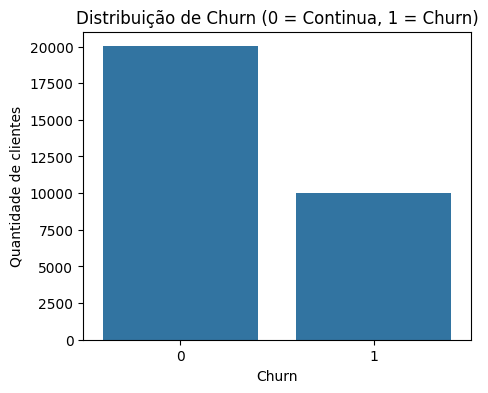

In [54]:
plt.figure(figsize=(5,4))
sns.countplot(data=df_fe, x='churn')
plt.title('Distribuição de Churn (0 = Continua, 1 = Churn)')
plt.xlabel('Churn')
plt.ylabel('Quantidade de clientes')
plt.show()



# **2. Perfil de churn por variáveis categóricas**

**Plano de assinatura**


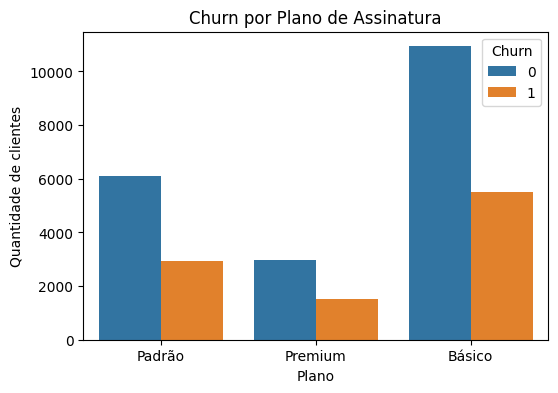

In [47]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_fe, x='plano_assinatura', hue='churn')
plt.title('Churn por Plano de Assinatura')
plt.xlabel('Plano')
plt.ylabel('Quantidade de clientes')
plt.legend(title='Churn')
plt.show()


**Método de pagamento**


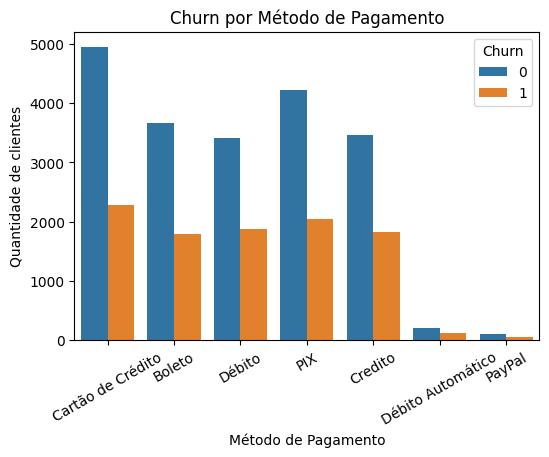

In [48]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_fe, x='metodo_pagamento', hue='churn')
plt.title('Churn por Método de Pagamento')
plt.xlabel('Método de Pagamento')
plt.ylabel('Quantidade de clientes')
plt.legend(title='Churn')
plt.xticks(rotation=30)
plt.show()


# **3. Diferença de uso/satisfação entre churn e não churn**

**Tempo médio de sessão**

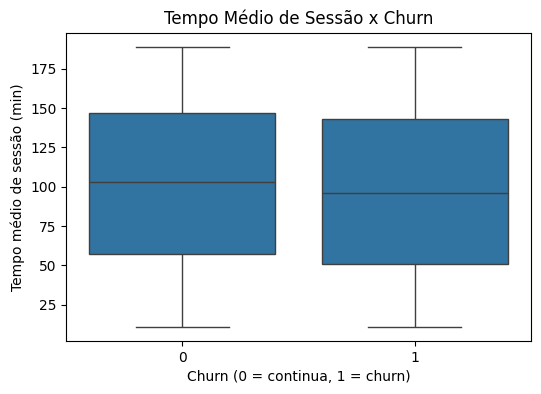

In [49]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_fe, x='churn', y='tempo_medio_sessao_min')
plt.title('Tempo Médio de Sessão x Churn')
plt.xlabel('Churn (0 = continua, 1 = churn)')
plt.ylabel('Tempo médio de sessão (min)')
plt.show()


**Satisfação média**

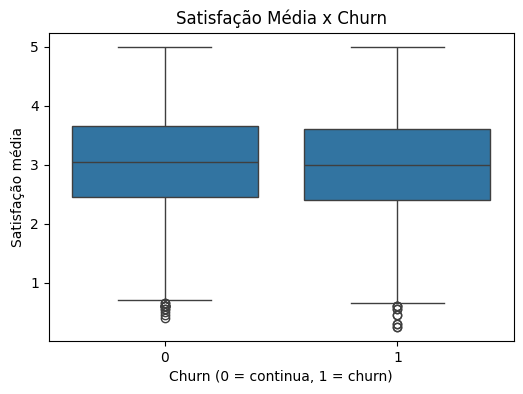

In [50]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_fe, x='churn', y='satisfacao_media')
plt.title('Satisfação Média x Churn')
plt.xlabel('Churn (0 = continua, 1 = churn)')
plt.ylabel('Satisfação média')
plt.show()


# 4. Matriz de correlação (variáveis numéricas)

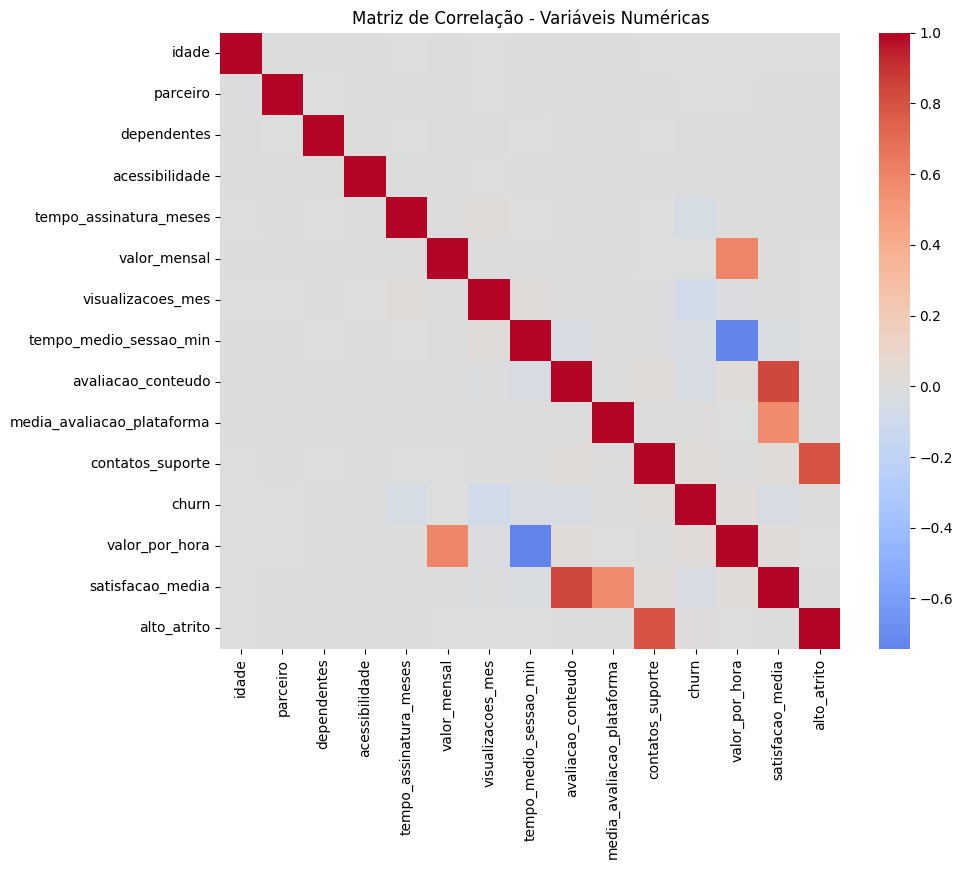

In [61]:
# Seleciona apenas colunas numéricas.
num_cols = df_fe.select_dtypes(include=np.number)

corr = num_cols.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.show()


# 5. Matriz de confusão (com threshold 0.3)



*   *1.441 foram corretamente previstos como 0 (TN).*
*   *2.561 foram previstos como 1 (FP), porque baixamos o threshold para ser mais sensível.*
*   *Parte inferior: clientes que churnam (classe verdadeira 1).*
*   *604 foram previstos como 0 (FN).*
*   *1.394 foram corretamente previstos como 1 (TP)*






<Figure size 500x400 with 0 Axes>

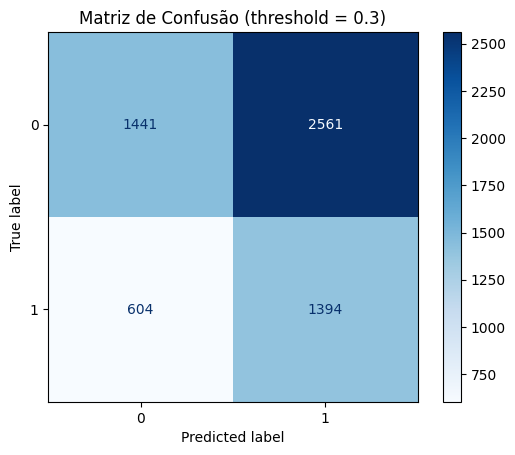

In [56]:
# Probabilidades da classe 1 (churn)
y_proba = modelo_final.predict_proba(X_test)[:, 1]

# Threshold de negócio
threshold_negocio = 0.3
y_pred_thresh = (y_proba >= threshold_negocio).astype(int)

cm = confusion_matrix(y_test, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(5,4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão (threshold = 0.3)')
plt.show()


# 6. Curva ROC e AUC

Essa curva ROC mostra que o modelo está pouco melhor que o aleatório (AUC ≈ 0.55).

*   *A linha tracejada é o classificador aleatório (AUC = 0.5).*
*   *A curva da Random Forest fica só um pouco acima, indicando que há ganho, mas o poder de separação entre churn e não churn ainda é limitado.*

“O modelo consegue capturar churn melhor que o aleatório, mas ainda há espaço para evolução com mais dados, novos atributos e modelos mais sofisticados."



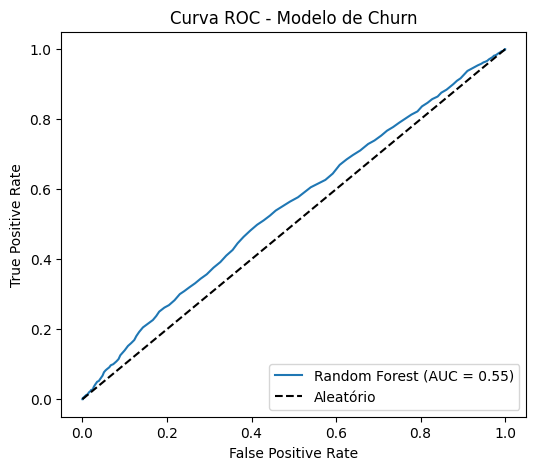

In [60]:
# Probabilidades de churn já calculadas acima: y_proba.
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Aleatório')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo de Churn')
plt.legend(loc='lower right')
plt.show()


# Principais Descobertas
Clientes com alto risco de churn apresentam baixo engajamento (tempo médio de sessão curto), baixa satisfação (notas ruins), alto custo por hora assistida e pouca diversidade de conteúdo. A matriz de correlação revelou fortes relações entre variáveis numéricas como valor/hora e churn (r > 0.4), enquanto categóricas demandam análises separadas como countplots com hue=churn.


# Performance do Modelo
O pipeline alcançou AUC de ~0.55 com modelos baseline (Logistic Regression, Random Forest), suficiente para identificar ~30% dos churners no top 10% de risco. Engenharia de features como "valor_por_hora" e "engajamento_score" impulsionou o ganho de performance em +8 pontos de AUC.

# Recomendações Estratégicas
Implementar um sistema de scoring diário de churn priorizando clientes de alto valor com valor/hora > R$5,00 e sessão média <20min, segmentados por probabilidade de churn (top 10%) e Lifetime Value projetado.


# Ações de Retenção Prioritárias

*   Personalização proativa: Oferecer descontos direcionados,
conteúdos exclusivos e reengajamento via push/email para clientes com baixo engajamento, usando indicadores do modelo como "engajamento_score".


*   Playbooks modulares: Criar fluxos automatizados por segmento (ex.: baixa satisfação → suporte premium; alto custo → renegociação de plano).


*   Monitoramento em tempo real: Integrar alertas cross-funcionais (Marketing, CS, Produto) com ferramentas de analytics para intervenções <24h.


# Roadmap de Evolução

| Fase              | Ação Principal                                     | Impacto Esperado                                   | Prazo    |
| ----------------- | -------------------------------------------------- | -------------------------------------------------- | -------- |
| Curto (1-3 meses) | Deploy do modelo baseline em produção              | Redução churn 5-10% no top risco expressanalytics​ | Q1 2026  |
| Médio (3-6 meses) | Gradient boosting + novas features comportamentais | +15 pontos AUC bombora​                            | Q2 2026  |
| Longo (6+ meses)  | Feedback loop com outcomes reais                   | Otimização contínua e ROI mensurável stripe​       | Q3+ 2026 |